# N-Gram model to cluster code into clusters

This model was based on [Kristian Wahlroos's](https://github.com/wakr/MSc-Thesis) MSc research and source code to prototype a n-gram based modeling, used for plagiarism detection, to instead just return the clusters as is.


In [1]:
import numpy as np
import pandas as pd
import scipy
import psycopg2

import matplotlib.pyplot as plt

import os
import json

In [2]:
def parse_testdata(path='../data/rainfall-submissions.tsv'):
    file = open(path,'r')
    raw = file.readlines()
    file.close()
    res = dict()
    exid = "3c79c115-0f5f-4d8e-b02c-b4b33155a4b3"
    get_code = lambda data: data["mooc-2017-ohjelmointi"]["osa02-Osa02_16.MarsinLampotilanKeskiarvo"]["/src/MarsinLampotilanKeskiarvo.java"]
    for line in raw:
        id = line[:len(exid)]
        body = json.loads(line[len(exid):])
        res[id] = get_code(body)
    return res

rain = parse_testdata()

In [3]:
import re

def normalize(source_code):
    res = re.sub("import.*;", "", source_code)
    res = re.sub("\".+\"", "\"\"", res)
    res = re.sub("\t+", "", res)
    res = re.sub("\n", "", res)
    res = re.sub("\s+", " ", res)
    res = re.sub("({|})", " ", res)
    res = re.sub("\d+", "t0", res)
    res = re.sub("(for|while)", "loop", res)
    return res

def normalize_for_ai(source_code):
    res = re.sub("\/\*.*\*\/", "", source_code, flags=re.DOTALL) # multiline comment
    res = re.sub("\/\/.*", "", res) # inline comments
    res = re.sub("\".+\"", "\"\"", res) # string values
    res = re.sub("\d+", "$", res)
    return res

def normalize_for_ast(source_code):
    res = re.sub("import.*;", "", source_code)
    res = re.sub("package.*;", "", res)
    return res


In [4]:
import antlr4
from antlr_local.JavaLexer import JavaLexer
from antlr_local.JavaParser import JavaParser
from antlr_local.JavaParserListener import JavaParserListener
from MyListener import KeyPrinter
import pprint

from antlr4 import RuleContext

import glob

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def parse_to_compositional_tokens(code):
    #print("parsing: ", self.ID)
    code_stream = antlr4.InputStream(code)
    lexer = JavaLexer(code_stream)
    token_stream = antlr4.CommonTokenStream(lexer)
    parser = JavaParser(token_stream)
    tree = parser.compilationUnit()

    printer = KeyPrinter()
    walker = antlr4.ParseTreeWalker()
    walker.walk(printer, tree)

    return printer.get_result()

def parse_data(codeDict):
    ids = list(codeDict.keys())
    token_list = [None] * len(ids)
    normalized_list = [None] * len(ids)
    for i in range(0, len(ids)):
        c = codeDict[ids[i]]
        token_list[i] = parse_to_compositional_tokens(c)
        normalized_list[i] = normalize_for_ai(c)
    return token_list, normalized_list
   

tlist, nlist = parse_data(rain)
df = pd.DataFrame({ "token_stream": tlist, "normalized": nlist })

Here is guess you can change the `ngram_range` parameter to optimize the model to use only a specific amount of ngrams. As Kristian stated in his research, a higher value will make the most unique groups even more unique but there's some optimal ratio between 3-5 n-grams.

In [5]:
ngram_vectorizer = CountVectorizer(analyzer='word', 
                                   ngram_range=(5, 5),
                                   token_pattern="[\S]+",
                                   lowercase= False,
                                   strip_accents="ascii")

#transformer = TfidfTransformer(smooth_idf=True, norm=None)
transformer = TfidfTransformer(smooth_idf=False)

X = ngram_vectorizer.fit_transform(df.token_stream)
tfidf = transformer.fit_transform(X)

res_tf = pd.DataFrame(X.A, columns=ngram_vectorizer.get_feature_names())

res_idf = pd.DataFrame(tfidf.A, columns=ngram_vectorizer.get_feature_names())

In [6]:
res_idf

,APPLY APPLY BREAK IF{ ASSIGN,APPLY APPLY BREAK }IF }IF,APPLY APPLY IF{ ASSIGN APPLY,APPLY APPLY IF{ ASSIGN ASSIGN,APPLY APPLY IF{ ASSIGN BREAK,APPLY APPLY IF{ ASSIGN VARDEF,APPLY APPLY IF{ IF{ ASSIGN,APPLY APPLY LOOP{ ASSIGN IF{,APPLY APPLY VARDEF ASSIGN IF{,APPLY APPLY VARDEF ASSIGN VARDEF,...,}LOOP APPLY APPLY }METHOD }CLASS,}LOOP ASSIGN APPLY APPLY }METHOD,}LOOP ASSIGN APPLY }METHOD }CLASS,}LOOP IF{ ASSIGN APPLY APPLY,}LOOP RETURN }METHOD METHOD{ GENERIC,}LOOP VARDEF ASSIGN APPLY APPLY,}LOOP VARDEF ASSIGN APPLY }METHOD,}LOOP VARDEF ASSIGN VARDEF ASSIGN,}METHOD METHOD{ GENERIC RETURN APPLY,}METHOD METHOD{ GENERIC VARDEF ASSIGN
0,0.0,0.0,0.000000,0.0,0.118352,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.133996,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.159535,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.108708,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.107280,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.381592,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0.0,0.0,0.248352,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
106,0.0,0.0,0.000000,0.0,0.108739,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
107,0.0,0.0,0.000000,0.0,0.128104,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.296301,0.0,0.0,0.0
108,0.0,0.0,0.000000,0.0,0.159535,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [7]:
dist_matrix

NameError: name 'dist_matrix' is not defined

[t-SNE] Computing 109 nearest neighbors...
[t-SNE] Indexed 110 samples in 0.000s...
[t-SNE] Computed neighbors for 110 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 110 / 110
[t-SNE] Mean sigma: 0.528240
[t-SNE] Computed conditional probabilities in 0.007s
[t-SNE] Iteration 50: error = 55.1339722, gradient norm = 0.5252853 (50 iterations in 0.034s)
[t-SNE] Iteration 100: error = 54.4007034, gradient norm = 0.5087386 (50 iterations in 0.034s)
[t-SNE] Iteration 150: error = 57.6445122, gradient norm = 0.4202242 (50 iterations in 0.049s)
[t-SNE] Iteration 200: error = 57.3071976, gradient norm = 0.4659762 (50 iterations in 0.043s)
[t-SNE] Iteration 250: error = 53.7159843, gradient norm = 0.5225714 (50 iterations in 0.035s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.715984
[t-SNE] Iteration 300: error = 0.7697281, gradient norm = 0.0110593 (50 iterations in 0.044s)
[t-SNE] Iteration 350: error = 0.5151376, gradient norm = 0.0055351 

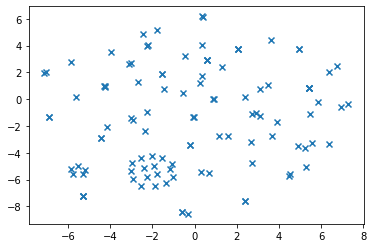

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn import manifold

from mpl_toolkits.mplot3d import Axes3D

# TODO: Add treshold

sim_matrix = np.around(cosine_similarity(tfidf), decimals=8)
dist_matrix = np.subtract(np.ones(sim_matrix.shape,  dtype=np.int8), sim_matrix) # sim <=> 1 - dist

X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(tfidf)
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)
#%%
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker="x")

In [9]:
from sklearn.cluster import DBSCAN

db = DBSCAN(min_samples=2, metric="precomputed", eps=0.05).fit(dist_matrix)
labels = db.labels_ # -1 = noise
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels) 

labels

array([ 0,  1,  2, -1,  3,  4, -1, -1,  2, -1, -1, -1,  5, -1,  4, -1,  2,
        6, -1, -1,  2,  7, -1, -1,  8,  7, -1, -1, -1,  2,  2, -1,  2, -1,
        0, -1,  2, -1, -1, -1, -1, -1,  8, -1,  9,  6, -1, -1,  4, -1, -1,
       -1,  3,  6, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,  2,  0, -1,
       -1, -1, -1, -1, -1, -1,  1, -1,  2, -1, -1, -1, -1,  2, -1,  9, 10,
       -1,  2, -1, -1, -1,  2,  3,  2, -1, -1,  2, -1,  7, -1, -1, -1,  5,
        4, -1, -1, -1, 10,  4,  2, -1])

In [10]:
def create_clusters(labels):
    clusters = {}
    for i, c in enumerate(labels):
        if c == -1: continue
        if not c in clusters.keys():
            clusters[c] = [i]
        else:
            clusters[c].append(i)
    return clusters

clusters = create_clusters(labels)

In [11]:
clusters

{0: [0, 34, 56, 66],
 1: [1, 74],
 2: [2, 8, 16, 20, 29, 30, 32, 36, 65, 76, 81, 86, 90, 92, 95, 108],
 3: [4, 52, 91],
 4: [5, 14, 48, 102, 107],
 5: [12, 101],
 6: [17, 45, 53],
 7: [21, 25, 97],
 8: [24, 42],
 9: [44, 83],
 10: [84, 106]}

In [75]:
X_embedded

array([[ 5.427843  ,  0.8143881 ],
       [-0.24053124, -3.4181557 ],
       [-2.922514  , -5.9516206 ],
       [ 6.3838325 ,  2.002096  ],
       [-5.294088  , -7.2229404 ],
       [-5.304881  , -5.5637107 ],
       [ 4.4665527 , -5.7410736 ],
       [-0.01167047, -1.2915883 ],
       [-1.035312  , -5.7983427 ],
       [ 0.2365289 ,  1.2044857 ],
       [ 0.3164308 , -5.456952  ],
       [ 1.5977633 , -2.7477949 ],
       [-1.5309519 ,  1.8609726 ],
       [ 5.4887586 , -1.0874926 ],
       [-5.220043  , -5.296802  ],
       [ 0.68614626, -5.5324883 ],
       [-1.9176959 , -4.9819317 ],
       [ 2.0494318 ,  3.7278223 ],
       [-0.06171695, -1.3315674 ],
       [ 0.40784085,  6.1528387 ],
       [-2.0165112 , -4.202733  ],
       [ 0.579525  ,  2.9403443 ],
       [ 5.2617445 , -3.663276  ],
       [ 1.319605  ,  2.384879  ],
       [-4.4318223 , -2.886845  ],
       [ 0.5795252 ,  2.9403446 ],
       [-2.4534152 ,  4.827777  ],
       [ 0.36710173,  1.7141126 ],
       [-5.8886046 ,

In [80]:
np.round(X_embedded[0][0].item(), 3).item()

5.428

In [69]:
r = np.round(X_embedded, 3)

In [73]:
r[0][0].item()

5.427999973297119

In [33]:
print(a)

None


In [31]:
a = {}.get('name')

## The same model modified for the API

In [35]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn import manifold
from sklearn.cluster import DBSCAN

import hdbscan
import umap

import antlr4
from antlr4 import RuleContext

from antlr_local.JavaLexer import JavaLexer
from antlr_local.JavaParser import JavaParser
from antlr_local.JavaParserListener import JavaParserListener
from MyListener import KeyPrinter
from java_tokens import interestingTokenTypes, rareTokenTypes

import os
import json
import re
import glob
import pprint
from collections import Counter

def parse_testdata(path='../data/rainfall-submissions.tsv'):
    file = open(path,'r')
    raw = file.readlines()
    file.close()
    res = dict()
    exid = "3c79c115-0f5f-4d8e-b02c-b4b33155a4b3"
    get_code = lambda data: data["mooc-2017-ohjelmointi"]["osa02-Osa02_16.MarsinLampotilanKeskiarvo"]["/src/MarsinLampotilanKeskiarvo.java"]
    for line in raw:
        id = line[:len(exid)]
        body = json.loads(line[len(exid):])
        res[id] = get_code(body)
    return res

def normalize_for_ai(source_code):
    res = re.sub("\/\*.*\*\/", "", source_code, flags=re.DOTALL) # multiline comment
    res = re.sub("\/\/.*", "", res) # inline comments
    res = re.sub("\".+\"", "\"\"", res) # string values
    res = re.sub("\d+", "$", res)
    return res

def counts_to_id_dict(ids, counts):
    d = {}
    for i, c in enumerate(counts):
        if None in c:
            c.pop(None)
        if len(c) != 0:
            d[ids[i]] = dict(c)
    return d

def parse_to_compositional_tokens(code):
    code_stream = antlr4.InputStream(code)
    lexer = JavaLexer(code_stream)
    token_stream = antlr4.CommonTokenStream(lexer)
    parser = JavaParser(token_stream)
    tree = parser.compilationUnit()

    printer = KeyPrinter()
    walker = antlr4.ParseTreeWalker()
    walker.walk(printer, tree)

    return printer.get_result()

def parse_to_keyword_tokens(code):
    code_stream = antlr4.InputStream(code)
    lexer = JavaLexer(code_stream)
    token_stream = antlr4.CommonTokenStream(lexer)
    parser = JavaParser(token_stream)
    tree = parser.compilationUnit()

    allTypes = [t.type for t in token_stream.tokens]
    interestingTokens = [interestingTokenTypes[t] for t in allTypes if t in interestingTokenTypes]
    rareTokens = [rareTokenTypes[t] for t in allTypes if t in rareTokenTypes]
    return interestingTokens, rareTokens

def parse_ast_modified(codeList):
    n = len(codeList)
    token_list = [None] * n
    normalized_list = [None] * n
    for i, c in enumerate(codeList):
        token_list[i] = parse_to_compositional_tokens(c)
        normalized_list[i] = normalize_for_ai(c)
    return token_list, normalized_list

def parse_ast_keywords(codeList):
    n = len(codeList)
    keywords = [None] * n
    rareKeywords = [None] * n
    for i, c in enumerate(codeList):
        intTokens, rareTokens = parse_to_keyword_tokens(c)
        keywords[i] = intTokens
        rareKeywords[i] = rareTokens
    return keywords, rareKeywords

def create_clusters(labels):
    clusters = {}
    for i, c in enumerate(labels):
        if not c in clusters:
            clusters[c] = [i]
        else:
            clusters[c].append(i)
    return clusters

def create_token_df(token_set, codeList):
    if token_set == 'modified':
        tlist, nlist = parse_ast_modified(codeList)
        return pd.DataFrame({ "token_stream": tlist })
    else:
        keywords, rareKeywords = parse_ast_keywords(codeList)
        return pd.DataFrame({ "token_stream": list(map(lambda x: ' '.join(x), keywords)) })

def cluster_dist_matrix(dist_matrix, clustering_params):
    params = clustering_params or {}
    name = params.get('name')
    if name == 'HDBSCAN':
        min_cluster_size = params.get('min_cluster_size') or 2
        return_dendrogram = params.get('return_dendrogram') or False
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            gen_min_span_tree=return_dendrogram
        )
        clusterer.fit(dist_matrix)
        #plt.figure(3, figsize=(24,8)) 
        #clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
        return clusterer.labels_
    else:
        eps = params.get('eps') or 0.05
        db = DBSCAN(min_samples=2, metric="precomputed", eps=eps).fit(dist_matrix)
        return db.labels_

def reduce_to_2d(X_reduced, dim_visualization_params={}):
    params = dim_visualization_params or {}
    name = params.get('name')
    if name == 'UMAP':
        n_neighbors = params.get('n_neighbors') or 30
        min_dist = params.get('min_dist') or 0.0
        return umap.UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            n_components=2
        ).fit_transform(X_reduced)
    else:
        perplexity = params.get('perplexity') or 30
        return TSNE(
            n_components=2,
            perplexity=perplexity
        ).fit_transform(X_reduced)

def run_ngram(submissionIds, codeList, token_set='modified', ngrams=(3,3), svd_n_components=50,
              clustering_params={}, dim_visualization_params={}):

    documents = len(codeList)
    df = create_token_df(token_set, codeList)

    ngram_vectorizer = CountVectorizer(analyzer='word', 
                                       ngram_range=ngrams,
                                       token_pattern="[\S]+",
                                       lowercase=False,
                                       strip_accents="ascii")

    #transformer = TfidfTransformer(smooth_idf=True, norm=None)
    transformer = TfidfTransformer(smooth_idf=False)

    X = ngram_vectorizer.fit_transform(df.token_stream)
    tfidf = transformer.fit_transform(X)

    res_tf = pd.DataFrame(X.A, columns=ngram_vectorizer.get_feature_names())

    res_idf = pd.DataFrame(tfidf.A, columns=ngram_vectorizer.get_feature_names())

    sim_matrix = np.around(cosine_similarity(tfidf), decimals=8)
    dist_matrix = np.subtract(np.ones(sim_matrix.shape, dtype=np.int8), sim_matrix) # sim <=> 1 - dist

    X_reduced = TruncatedSVD(n_components=svd_n_components, random_state=0).fit_transform(tfidf)
    X_embedded = reduce_to_2d(X_reduced, dim_visualization_params)

    labels = cluster_dist_matrix(dist_matrix, clustering_params)
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    unique_labels = set(labels) 

    labels_list = labels.tolist()
    clusters = create_clusters(labels_list)
    true_label_clusters = {k : [submissionIds[i] for i in v] for k, v in clusters.items()}
    coordinates = [{
        'id': submissionIds[i],
        'x': d[0],
        'y': d[1],
        'cluster': labels_list[i]
        } for (i, d) in enumerate(X_embedded)]

    return {
        "clusters": true_label_clusters,
        "2d": coordinates,
    }


In [36]:
import psycopg2
from dotenv import load_dotenv

import os
import json

load_dotenv()

POSTGRES_HOST = os.getenv("DB_HOST")
POSTGRES_PORT = os.getenv("DB_PORT")
POSTGRES_DB = os.getenv("DB_NAME")
POSTGRES_USER = os.getenv("DB_USER")
POSTGRES_PASSWORD = os.getenv("DB_PASSWORD")

conn = psycopg2.connect(host=POSTGRES_HOST, port=POSTGRES_PORT, database=POSTGRES_DB, user=POSTGRES_USER, password=POSTGRES_PASSWORD)

cur = conn.cursor()

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

def query_many(query):
    cur.execute(query)
    return cur.fetchall()

def cluster_submissions(courseId, exerciseId):
    rows = query_many(f"""
    SELECT submission_id, code FROM submission WHERE course_id = {courseId} AND exercise_id = {exerciseId}
    """)
    submissionIds = [r[0] for r in rows]
    codeList = [r[1] for r in rows]
    # print(codeList)
    ngram_result = run_ngram(submissionIds, codeList)
    return {
        "ngram": ngram_result,
    }


r = cluster_submissions(2, 4)

In [37]:
r

{'ngram': {'clusters': {0: ['e1161ada-3320-4689-83ad-0a5db127b115',
    'f2c2118b-4c83-409f-80be-3d7bde4f78fc',
    '652be2e5-e6bf-4f2f-8757-bfa014701728',
    'de1865e5-af0a-4ad7-94f5-86005d550ece'],
   1: ['8fca7aae-8df5-47cb-858f-bb2e29b75552',
    '4cc30787-f3bc-4dd3-9c7f-c94dc53bdff8',
    '2a905dfb-57b7-4342-abe9-580a0a5c871f',
    'ebe27463-0af4-4293-8c07-7e8b5b015afe',
    '831aca0e-b7b6-462b-bbcf-d77ef43a1c93',
    '9693512b-64af-4441-897c-8390843f14ac',
    '542ea3be-056e-401c-ae21-038c52101d17',
    'e2eeeead-8cbf-4143-9bb6-d792ca55fdb9',
    'bcbe8f22-8be9-481b-ae8f-f47c5e818078',
    'ca6ee39d-e0a7-4629-91d0-fe33e09fab50',
    '643cbe02-1541-4028-b221-60ccf74de912',
    'fad25999-9adf-4c2e-ad00-e9ed96577e3d',
    'a9cf3488-c35b-4711-a28f-6c0b05cd5d28',
    '62cc90dc-0404-41d6-a629-44fc8c669a3e',
    '429a035f-798e-40ea-b6d0-0ec001aa168f',
    'ad12b374-abd0-4248-80b0-7c8d7145bebb'],
   2: ['800d0eca-ad68-4ac6-9842-be4a851cab39',
    '98d481c4-392c-4448-b91d-0940def196cf'],

In [13]:
mat = r['filter']['matches']
v = np.ones(len(mat))
v @ mat

array([260., 260., 182., 260.])

In [14]:
mat.T @ v

array([260., 260., 182., 260.])

In [15]:
np.sum(mat, axis=1) / 4

array([1.  , 0.75, 0.75, 0.75, 1.  , 1.  , 1.  , 1.  , 0.75, 0.75, 1.  ,
       1.  , 0.75, 0.75, 1.  , 0.75, 1.  , 0.75, 1.  , 0.75, 1.  , 0.75,
       1.  , 0.75, 1.  , 1.  , 1.  , 1.  , 1.  , 0.75, 0.75, 1.  , 1.  ,
       0.75, 0.75, 1.  , 1.  , 0.75, 0.75, 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.75, 0.75,
       0.75, 1.  , 1.  , 0.75, 1.  , 1.  , 0.75, 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 0.75, 1.  , 1.  , 1.  , 1.  , 1.  , 0.75,
       1.  , 0.75, 0.75, 1.  , 0.75, 1.  , 0.75, 1.  , 0.75, 1.  , 1.  ,
       0.75, 1.  , 1.  , 1.  , 1.  , 0.75, 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 0.75, 1.  , 1.  , 1.  , 1.  , 0.75, 0.75, 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 0.75, 1.  , 0.75, 1.  , 0.75, 1.  ,
       0.75, 1.  , 1.  , 0.75, 1.  , 1.  , 0.75, 1.  , 1.  , 1.  , 1.  ,
       1.  , 0.75, 1.  , 0.75, 1.  , 1.  , 1.  , 1.  , 0.75, 0.75, 1.  ,
       1.  , 0.75, 1.  , 1.  , 1.  , 1.  , 0.75, 1.

In [111]:
x = np.ones((len(mat), 4))
mat @ x

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 260 is different from 4)

In [98]:
np.dot(v, mat)

array([260., 260., 182., 260.])

In [66]:
dict(rows)

{1: "#include <stdio.h>\nvoid main() {\n  printf('Hello There');\n}",
 2: "#include <stdio.h>\nint main() {\n  printf('Hello There');\n  return 0;\n}",
 3: '\nimport java.util.Scanner;\n\npublic class MarsinLampotilanKeskiarvo {\n\n    public static void main(String[] args) {\n        Scanner lukija = new Scanner(System.in);\n        \n        int summa = 0;\n        int syotteet = 0;\n        \n        while (true) {\n            System.out.print("Syötä luku: ");\n            int syote = Integer.parseInt(lukija.nextLine());\n            \n            if (syote == 9999) {\n                break;\n            } else if (syote <= 20 && syote >= -140) {\n                summa += syote;\n                syotteet++;\n            }\n        }\n        \n        System.out.println("Mittausten keskiarvo: " \n                            + (double) summa / syotteet );\n    }\n}\n',
 4: '\nimport java.util.Scanner;\n\npublic class MarsinLampotilanKeskiarvo {\n\n    public static void main(String[

In [33]:
submission_ids = [
  "d1b3fd4b-18db-4c02-a2f7-77f82f33ac42",
  "9e451f22-ae10-4318-9d31-bd338752e4bd",
  "9d1e5e4d-e0b7-4676-864b-061c569c0e2e",
  "5bec3b9c-716d-4db4-90d4-8f8bbdc462de",
  "53aca0f5-122c-49bf-97d6-89abdde180e8",
  "bee5dad6-60c3-45c7-8251-f0f9a2ee3c97",
  "2d9ffd7e-cba9-4252-b9fd-c464afb05a52",
  "8b27ec6c-6e8f-45ae-b2b8-245f7114c229",
  "598f02a1-4e5d-461d-9079-ec58c06c845a",
  "92b37ff8-4620-4641-8054-fb5233163006",
  "2923d62d-25ba-473c-8e26-48a33c1cef60",
  "e197dfbf-029f-432c-aec5-5772919f8194",
  "2466d688-ea96-45d5-b55d-a7959f598089",
  "33c51cd8-227f-4690-8739-1828cdfa9ac0",
  "1c6f15f8-6fec-42da-a2ac-7511c39c4eb8",
  "b4e8f6cd-4535-4ea0-bdec-837d1cdfcc43",
  "bd151cfe-ae92-44b7-83ec-5c9be1b54f89",
  "0e4347e4-d2d4-46be-8379-d8378273d8de",
  "a2b728f8-8288-4afb-82aa-f1b007808444",
  "b4b9477c-fd39-43ff-b45c-4c794e24847c",
  "a3471776-9a21-450a-b7c1-a806cf8b7719",
  "2fea7679-c6e6-458e-b3c7-50db6ebc910f",
  "d07f7dd8-c852-46d3-a9c7-221cc49c1462",
  "8e9146f4-fca5-4464-bcfd-0aaa9c4f503e",
  "7d742a83-7894-4cb8-b468-458a301133b7",
  "9683aff9-33b7-429c-a404-3cc2038eb564",
  "20a92498-bb21-4649-8c2f-0f12b624b793",
  "f3f167f5-5da1-4ab4-80c5-d98726734c99",
  "7f00993d-e99e-4922-81a8-08980a1b54e2",
  "4628178f-0592-43fe-a1ec-322109c3d3db",
  "37ba38c8-39ff-44b6-9935-55a721d38c77",
  "9937be86-c548-41bb-86ee-bfa4e89a7f6e",
  "22751a37-af83-4814-87f3-ad16eedc416c",
  "3e9f7628-b58e-4a13-b53d-5d9645d44227",
  "345e7c05-ba5f-4e0d-8b85-1a1a8ad17c3b",
  "b03b18f3-0baa-49e9-a71c-f87a9c75dc93",
  "5d5e632c-a3a8-40e3-b6bc-eca5ed162f96",
  "893bab02-f8de-4344-8d65-8ea75c8faa73",
  "5aff05bf-2d02-40b7-968c-e5c0066f1eb2",
  "773a3da0-d811-4b6a-b413-2b4fef01016e",
  "259fde24-4100-47aa-a3f3-71c350cd1b3a",
  "464b4820-4658-42c2-8206-a2dd654aa380",
  "3f2e4b7a-1f47-4882-bcdb-bf57c7fd3ebd",
  "9c754a0c-abe1-420b-9d8f-7186e59d8cd1",
  "1b948457-3034-40c9-9145-5acbc8ba5757",
  "1fd21093-0dcc-494f-bec5-bcef1ce6347a",
  "84e47a5d-c48d-4814-80c4-516767739375",
  "981b2cdc-00fb-48fd-ac3d-730fa81c5612",
  "f189c632-e3eb-4a16-91ab-5e6ae00b59c6",
  "e0136921-1ac5-41e7-98e7-9e0f2300cee5",
  "cb44a34d-337f-4ae0-a76d-43d9f9cfa98e",
  "7541f9c5-d13a-4596-b926-19f5cc6b8b10",
  "091f860a-76a2-45b3-adf7-786e0ccbd6ad",
  "7fe468db-5868-4a31-818e-6530b484685c",
  "84905e23-6e2f-4d80-8541-f2b22d4fd555",
  "f5e33f05-b195-45e6-8412-ba0f5c92cb21",
  "d5bac919-5186-439b-ac61-be36ff0bef68",
  "d70d2d30-d77a-4e79-87b3-d0e7edc93ca1",
  "8c755d5d-27e6-4b88-9629-485008e6c58a",
  "20c8dd0e-09fa-4305-a99f-9ef9118fdac9",
  "5946751d-2779-46ca-8158-e322016bcf86",
  "efb1c1a7-9aaf-4266-89f3-1d54b95c48ab",
  "4925f09e-2373-46e1-94cf-59371eff660e",
  "f84708bc-0586-499a-bd56-5c0936282d68",
  "37fc3223-8d7d-4350-9dd2-fcd61a0c5129",
  "d18df9f5-4f0e-4cad-acae-561d978b3a3c",
  "d6bc5fd2-8a4e-47b1-af2b-3d5c635a2b7d",
  "abe3bf47-fcac-4237-a50a-bc8f658e4aff",
  "70da1bb2-3c11-431d-bef1-9901bbf9ada1",
  "55ed8d97-3cae-4ba1-a4e6-8239ab831dd3",
  "ff05e878-898e-4568-b56b-77fb8b123186",
  "7199640e-ead6-4d8f-9d87-81bf79c728fd",
  "2963e07b-76d7-4f98-ba09-532774cb9d26",
  "479f3ca6-496b-4fc1-848b-c5778fb4414e",
  "78fc1a7a-1145-44b9-8dab-f3757fcdfc65",
  "5408dde3-14b8-40b8-8905-63040b97b708",
  "d9de9232-9f13-4e12-bb5c-e5037be1c399",
  "fdd512a3-0275-4767-adfe-08519c97c377",
  "e50f77db-666a-498c-b328-1d56d510ea6d",
  "5f1c4bc9-75b3-4950-9206-14e1148dd77c",
  "bd56feed-2664-439f-b154-a4ce4688ad98",
  "3e18eed3-f234-4f2c-90ae-172d581b7295",
  "030b2531-8579-4bf5-980a-2d6fcf9ba051",
  "4457ff34-f1c8-4b0e-ada1-a6493ac251b8",
  "cd1c04d6-466c-46cc-9e7a-0173033dd809",
  "7521aa6e-5d96-45b1-a1e2-03e3d2b67057",
  "75dd4b76-7592-4af0-b6b7-d04ff1bbb896",
  "1c3acf90-556c-434e-9623-78749f245132",
  "1a97f02c-0869-448c-a665-8c5540b2c1e1",
  "04274e9b-e60e-4213-9b97-acac56acb340",
  "9ec7f3fe-1a71-4d74-9f8e-1b40ddc3eb79",
  "0aa7f4e2-0bba-4bb7-9028-a59a8dceaa57",
  "3c3d4759-322e-4408-830b-23a58b2e4f79",
  "07830c30-260f-43d1-8428-7e704a682c99",
  "fc9d90fd-6770-4437-b68d-7a6717c25167",
  "e1a30419-5e7d-4ba3-90b9-445d16bca3b1",
  "9be58ba2-87c5-40ae-a3ef-c8b9a03ac4e8",
  "019d6f14-8713-467e-afb7-fcafd5da6d64",
  "0dab7865-3b61-4318-aa2a-fa3f1881a9ea",
  "1ada4e25-566d-464d-8015-f1049beef27c",
  "feeab917-52f8-4d53-9cec-e9224bebb0b8",
  "b7c635f2-70d4-421b-968b-9b6fc49952c4",
  "039de449-ddd8-4600-b596-e3020abec987",
  "30616d8b-7c9a-4f41-9e7d-691c4ddebcd2",
  "7247f002-7b7f-4f02-b2b7-e4cb3e8164a2",
  "3223eebf-73dd-46fb-9641-77b2d5301951",
  "a4af6e00-9a92-48b4-9a40-1701f0c82ce9",
  "b12a89f5-aae2-4787-8a7e-3d37e1ab9cd5",
  "c3c2de47-d897-493d-955a-cf67cb2326e9",
  "564b7746-3064-40b0-821b-098f12a86350",
  "61169a43-67fb-4419-8dd6-636fb368466f",
  "00e0f218-d58f-4184-9434-cf0b70c38d3f"
]

In [36]:
#submission_ids = ['d1b3fd4b-18db-4c02-a2f7-77f82f33ac42', '9e451f22-ae10-4318-9d31-bd338752e4bd', '9d1e5e4d-e0b7-4676-864b-061c569c0e2e']
query = f"""
SELECT submission_id, code FROM submission WHERE submission_id = ANY(array[{submission_ids}]::uuid[]);
"""

In [38]:
#courseId = 1
#exerciseId = 1
rows = query_many(f"""SELECT submission_id, code FROM submission WHERE submission_id = ANY(array{submission_ids}::uuid[])""")
codeList = [r[1] for r in rows]
codeList

["#include <stdio.h>\nvoid main() {\n  printf('Hello There');\n}",
 "#include <stdio.h>\nint main() {\n  printf('Hello There');\n  return 0;\n}",
 '\nimport java.util.Scanner;\n\npublic class MarsinLampotilanKeskiarvo {\n\n    public static void main(String[] args) {\n        Scanner lukija = new Scanner(System.in);\n        \n        int summa = 0;\n        int syotteet = 0;\n        \n        while (true) {\n            System.out.print("Syötä luku: ");\n            int syote = Integer.parseInt(lukija.nextLine());\n            \n            if (syote == 9999) {\n                break;\n            } else if (syote <= 20 && syote >= -140) {\n                summa += syote;\n                syotteet++;\n            }\n        }\n        \n        System.out.println("Mittausten keskiarvo: " \n                            + (double) summa / syotteet );\n    }\n}\n',
 '\nimport java.util.Scanner;\n\npublic class MarsinLampotilanKeskiarvo {\n\n    public static void main(String[] args) {\n 

In [40]:
rain = parse_testdata()

clusters, l = run_ngram(rain.values())
clusters

{0: [0, 34, 56, 66],
 1: [1, 74],
 2: [2, 8, 16, 20, 29, 30, 32, 36, 65, 76, 81, 86, 90, 92, 95, 108],
 3: [4, 52, 91],
 4: [5, 14, 48, 102, 107],
 5: [9, 27],
 6: [12, 101],
 7: [17, 45, 53],
 8: [21, 25, 97],
 9: [24, 42],
 10: [33, 38],
 11: [44, 83],
 12: [84, 106],
 13: [93, 105]}

In [35]:
l

array([ 0,  1,  2, -1,  3,  4, -1, -1,  2,  5, -1, -1,  6, -1,  4, -1,  2,
        7, -1, -1,  2,  8, -1, -1,  9,  8, -1,  5, -1,  2,  2, -1,  2, 10,
        0, -1,  2, -1, 10, -1, -1, -1,  9, -1, 11,  7, -1, -1,  4, -1, -1,
       -1,  3,  7, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,  2,  0, -1,
       -1, -1, -1, -1, -1, -1,  1, -1,  2, -1, -1, -1, -1,  2, -1, 11, 12,
       -1,  2, -1, -1, -1,  2,  3,  2, 13, -1,  2, -1,  8, -1, -1, -1,  6,
        4, -1, -1, 13, 12,  4,  2, -1])

In [46]:
clusters

{0: [0, 34, 56, 66],
 1: [1, 74],
 2: [2, 8, 16, 20, 29, 30, 32, 36, 65, 76, 81, 86, 90, 92, 95, 108],
 3: [4, 52, 91],
 4: [5, 14, 48, 102, 107],
 5: [12, 101],
 6: [17, 45, 53],
 7: [21, 25, 97],
 8: [24, 42],
 9: [44, 83],
 10: [84, 106]}

In [64]:
[{'id': submission_ids[i], 'x': d[0], 'y': d[1]} for (i, d) in enumerate(X_embedded)]

[{'id': 'd1b3fd4b-18db-4c02-a2f7-77f82f33ac42', 'x': 5.427843, 'y': 0.8143881},
 {'id': '9e451f22-ae10-4318-9d31-bd338752e4bd',
  'x': -0.24053124,
  'y': -3.4181557},
 {'id': '9d1e5e4d-e0b7-4676-864b-061c569c0e2e',
  'x': -2.922514,
  'y': -5.9516206},
 {'id': '5bec3b9c-716d-4db4-90d4-8f8bbdc462de', 'x': 6.3838325, 'y': 2.002096},
 {'id': '53aca0f5-122c-49bf-97d6-89abdde180e8',
  'x': -5.294088,
  'y': -7.2229404},
 {'id': 'bee5dad6-60c3-45c7-8251-f0f9a2ee3c97',
  'x': -5.304881,
  'y': -5.5637107},
 {'id': '2d9ffd7e-cba9-4252-b9fd-c464afb05a52',
  'x': 4.4665527,
  'y': -5.7410736},
 {'id': '8b27ec6c-6e8f-45ae-b2b8-245f7114c229',
  'x': -0.011670472,
  'y': -1.2915883},
 {'id': '598f02a1-4e5d-461d-9079-ec58c06c845a',
  'x': -1.035312,
  'y': -5.7983427},
 {'id': '92b37ff8-4620-4641-8054-fb5233163006',
  'x': 0.2365289,
  'y': 1.2044857},
 {'id': '2923d62d-25ba-473c-8e26-48a33c1cef60',
  'x': 0.3164308,
  'y': -5.456952},
 {'id': 'e197dfbf-029f-432c-aec5-5772919f8194',
  'x': 1.597763

In [57]:
def add_ids_to_clusters(clusters, submission_ids):
    return {k : [submission_ids[i] for i in v] for k, v in clusters.items()}
    #return {key: value for (key, value) in clusters}

clusters2 = add_ids_to_clusters(clusters, submission_ids)

In [58]:
clusters2

{0: ['d1b3fd4b-18db-4c02-a2f7-77f82f33ac42',
  '345e7c05-ba5f-4e0d-8b85-1a1a8ad17c3b',
  'd5bac919-5186-439b-ac61-be36ff0bef68',
  'd6bc5fd2-8a4e-47b1-af2b-3d5c635a2b7d'],
 1: ['9e451f22-ae10-4318-9d31-bd338752e4bd',
  '78fc1a7a-1145-44b9-8dab-f3757fcdfc65'],
 2: ['9d1e5e4d-e0b7-4676-864b-061c569c0e2e',
  '598f02a1-4e5d-461d-9079-ec58c06c845a',
  'bd151cfe-ae92-44b7-83ec-5c9be1b54f89',
  'a3471776-9a21-450a-b7c1-a806cf8b7719',
  '4628178f-0592-43fe-a1ec-322109c3d3db',
  '37ba38c8-39ff-44b6-9935-55a721d38c77',
  '22751a37-af83-4814-87f3-ad16eedc416c',
  '5d5e632c-a3a8-40e3-b6bc-eca5ed162f96',
  'd18df9f5-4f0e-4cad-acae-561d978b3a3c',
  'd9de9232-9f13-4e12-bb5c-e5037be1c399',
  '3e18eed3-f234-4f2c-90ae-172d581b7295',
  '75dd4b76-7592-4af0-b6b7-d04ff1bbb896',
  '9ec7f3fe-1a71-4d74-9f8e-1b40ddc3eb79',
  '3c3d4759-322e-4408-830b-23a58b2e4f79',
  'e1a30419-5e7d-4ba3-90b9-445d16bca3b1',
  'c3c2de47-d897-493d-955a-cf67cb2326e9'],
 3: ['53aca0f5-122c-49bf-97d6-89abdde180e8',
  '091f860a-76a2-45

In [34]:
matches, counts = group_by_strings(['summa', 'for'], list(rain.values()))


In [17]:
l

array([ 0,  1,  2, -1,  3,  4, -1, -1,  2,  5, -1, -1,  6, -1,  4, -1,  2,
        7, -1, -1,  2,  8, -1, -1,  9,  8, -1,  5, -1,  2,  2, -1,  2, 10,
        0, -1,  2, -1, 10, -1, -1, -1,  9, -1, 11,  7, -1, -1,  4, -1, -1,
       -1,  3,  7, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,  2,  0, -1,
       -1, -1, -1, -1, -1, -1,  1, -1,  2, -1, -1, -1, -1,  2, -1, 11, 12,
       -1,  2, -1, -1, -1,  2,  3,  2, 13, -1,  2, -1,  8, -1, -1, -1,  6,
        4, -1, -1, 13, 12,  4,  2, -1])

In [13]:
sum([len(clusters[k]) for k in clusters])

50

In [11]:
len(clusters.keys())

14

In [5]:
clusters

{0: [0, 34, 56, 66],
 1: [1, 74],
 2: [2, 8, 16, 20, 29, 30, 32, 36, 65, 76, 81, 86, 90, 92, 95, 108],
 3: [4, 52, 91],
 4: [5, 14, 48, 102, 107],
 5: [12, 101],
 6: [17, 45, 53],
 7: [21, 25, 97],
 8: [24, 42],
 9: [44, 83],
 10: [84, 106]}

In [2]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker="x")

clusters

NameError: name 'plt' is not defined